### Importing the required libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import PIL
from PIL import Image
import numpy as np
import pandas as pd
import torchvision.models as models
import importlib

#Custom modules
import helping_material
importlib.reload(helping_material)
from helping_material.helper_fns import *

In [67]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [22]:
import numpy as np

In [19]:
from sklearn.neighbors import NearestNeighbors

In [2]:
import torchvision.transforms as transforms

### Making the dataset, and dataloader

In [59]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

trans=transforms.Compose([transforms.Resize((500,500)),
                         transforms.ToTensor(),
                         transforms.Normalize(mean_nums,std_nums)])

In [4]:
images_path='data/5000-data/'
dataset=torchvision.datasets.ImageFolder(images_path,transform=trans)

In [5]:
dataset.classes

['.ipynb_checkpoints', 'images']

In [6]:
print(len(dataset))

5000


In [120]:
train_dataloader=torch.utils.data.DataLoader(dataset,batch_size=4,shuffle=True)

In [46]:
#filenames = [s for s in train_dataloader.dataset.samples[0]]
filenames=[s for (_,_,s) in data_set_data_dir]

In [60]:
len(filenames)

5000

In [78]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):    
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

dataset = ImageFolderWithPaths(root=images_path, transform=trans)
data_set_data_dir = torch.utils.data.DataLoader(dataset=dataset,batch_size=1)

for i, data in enumerate(data_set_data_dir):
    images,labels,paths = data
    print(paths[0])
    if i==4:
        break

data/5000-data/images/00016a0a0dfaab5b_4-1186.jpg
data/5000-data/images/0001a6410cdb0dc1_4-4740.jpg
data/5000-data/images/0001f2310da3ba6e_4-6170.jpg
data/5000-data/images/00110f800ca810d8_4-5081.jpg
data/5000-data/images/0011c5e10d0d2eab_4-6118.jpg


In [ ]:
for i,(images,_) in enumerate(train_dataloader,0):
#    show_tensor_images(images)
#    sample_fname, _ = test_loader.dataset.samples[i]
    print(i,train_dataloader.dataset.samples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


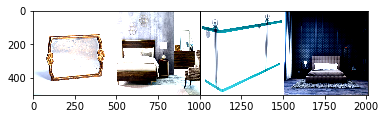

In [127]:
checking_loader=next(iter(train_dataloader))
#checking_loader[0].shape
show_tensor_images(checking_loader[0])

* So, that we cna easily shift between cpu, and gpu

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

* Loading the pretrained model

In [10]:
resnet_model=models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet50-19c8e357.pth


### Changing the model structure, for our use case

* We can also use this technique


model.classifier=nn.Sequential(*[model.classifier[i] for i in range(4)])

In [11]:
resnet_model.fc=nn.Identity()

In [ ]:
resnet_model.to(device)

In [31]:
#resnet_model

* Now using this model for getting the features of the images

In [79]:
features_list=[]
with torch.no_grad():
    for i,(images,_,_) in enumerate(data_set_data_dir):

        images=images.to(device)

        features=resnet_model(images)

        if i%200==0:
            print(features.shape)
        for i in range(features.shape[0]):
            features_list.append(features[i])


    

torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])
torch.Size([1, 2048])


In [80]:
print(len(features_list))
print(features_list[0].shape)

5000
torch.Size([2048])


* We need to have 2D array, for fitting the nearest neighbor algorith

In [81]:
features_list_array=np.array([features_list[i].cpu().numpy() for i in range(5000)])

In [82]:
features_list_array.shape

(5000, 2048)

### Fitting Nearest-Neighbor algorithm to extracted features

In [83]:
neighbors=NearestNeighbors(n_neighbors=5,algorithm='ball_tree',metric='euclidean')

In [84]:
neighbors.fit(features_list_array)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

### We need to have mapped filenames of all images, so that we can access them by indices, that are returned by Nearest-Neighbor Algorithm

In [48]:
# For this I have made Custom Dataloader, and got the names in filenames
filenames=filenames

### Now,we will extract the features of an image, not seen by model

In [111]:
test_img=Image.open('test_img3.jpeg')
test_img_t=trans(test_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


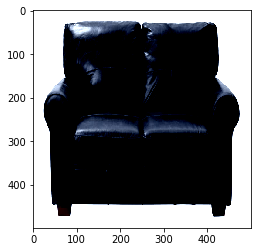

In [112]:
show_tensor_images(test_img_t)

* Getting the features

In [113]:
test_img_features=resnet_model(test_img_t.cuda().unsqueeze(0))
test_img_features.shape

torch.Size([1, 2048])

* Converting the features to numpy array

In [114]:
test_img_features_array=test_img_features.detach().cpu().numpy()

* Getting the indices of similar images

In [115]:
_, indices = neighbors.kneighbors(test_img_features_array)


In [116]:
indices[0]

array([2170, 4747, 4261, 3491,  973])

In [117]:
for i in indices[0]:
    path=filenames[i]
    print(path)

('data/5000-data/images/70a142540d092b3a_4-0598.jpg',)
('data/5000-data/images/f321af0c0c26b4c7_4-6201.jpg',)
('data/5000-data/images/d9a15d0a092ee310_4-5013.jpg',)
('data/5000-data/images/b401f1220e3b8fd5_4-0522.jpg',)
('data/5000-data/images/33b18fe60c2e1149_4-2956.jpg',)


* Showing the similar images

In [118]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(3,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index][0]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

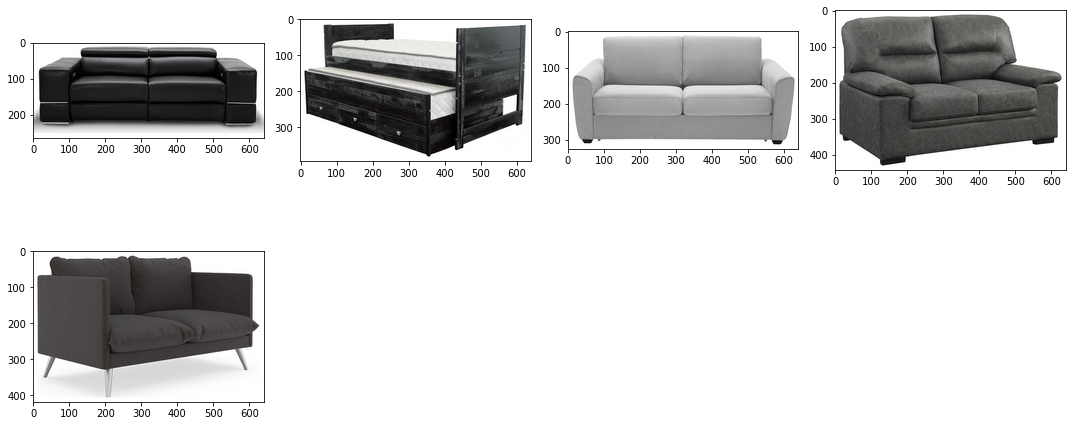

In [119]:
similar_images(indices[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


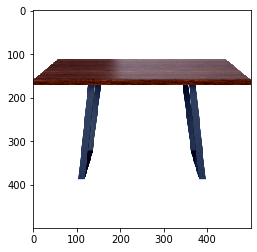

In [122]:
test_img_2=Image.open('TEST_TABLE.jpg')
test_img_t=trans(test_img_2)
show_tensor_images(test_img_t)

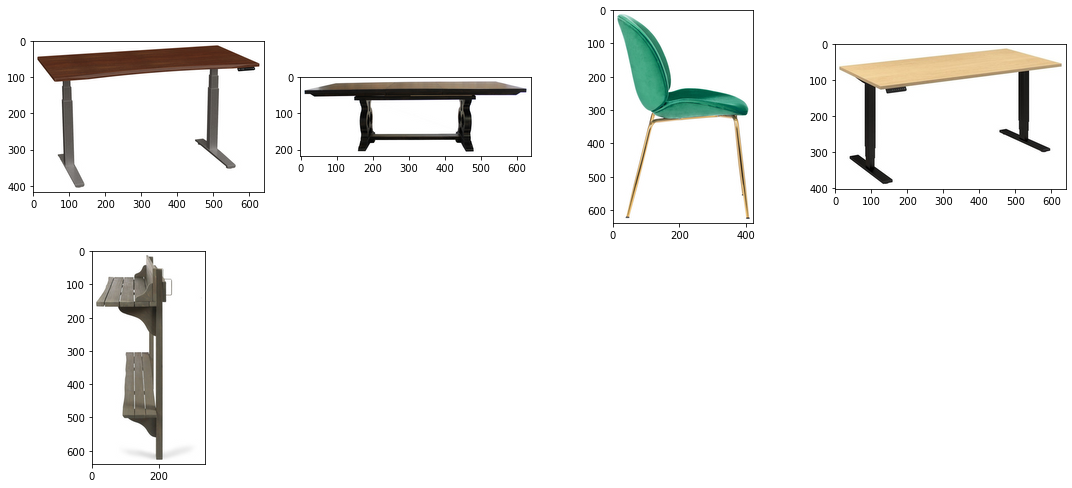

In [123]:
test_img_features=resnet_model(test_img_t.cuda().unsqueeze(0))
test_img_features_array=test_img_features.detach().cpu().numpy()
_, indices = neighbors.kneighbors(test_img_features_array)
similar_images(indices[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


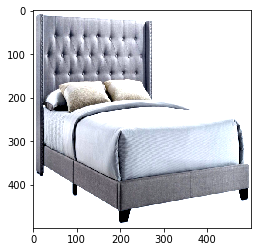

In [128]:
test_img_2=Image.open('TEST_BED.jpg')
test_img_t=trans(test_img_2)
show_tensor_images(test_img_t)

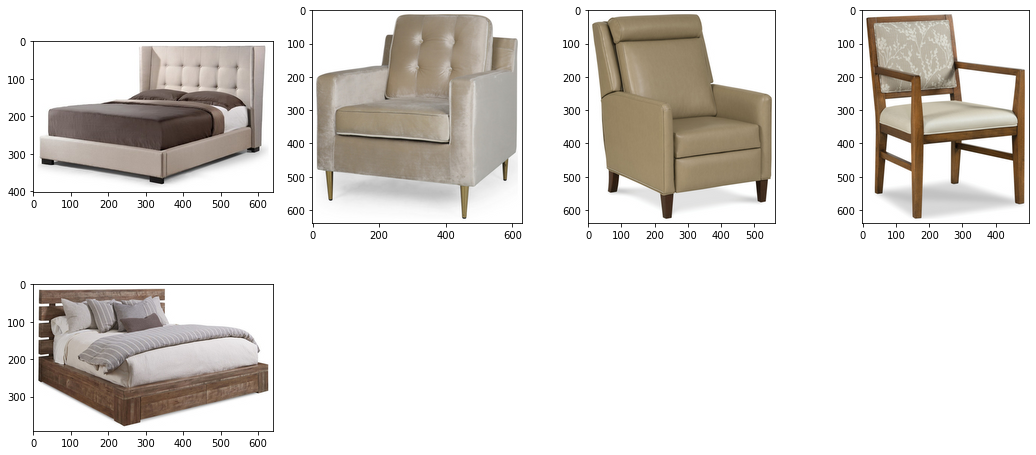

In [129]:
test_img_features=resnet_model(test_img_t.cuda().unsqueeze(0))
test_img_features_array=test_img_features.detach().cpu().numpy()
_, indices = neighbors.kneighbors(test_img_features_array)
similar_images(indices[0])

## So, it's pretty good that we are able to catch the complex features:

* As for two seater, black sofa we are getting almost all two seaters
* For table, we are getting 60% tables
* And for bed, we are having 2 beds, that's bad 